In [1]:
import numpy as np
from scipy import ndimage

import pandas as pd
from scipy import spatial

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
res_avg = np.mean([4.88918152, 4.88946346])
res_std = np.mean([0.00183618, 0.00167924])

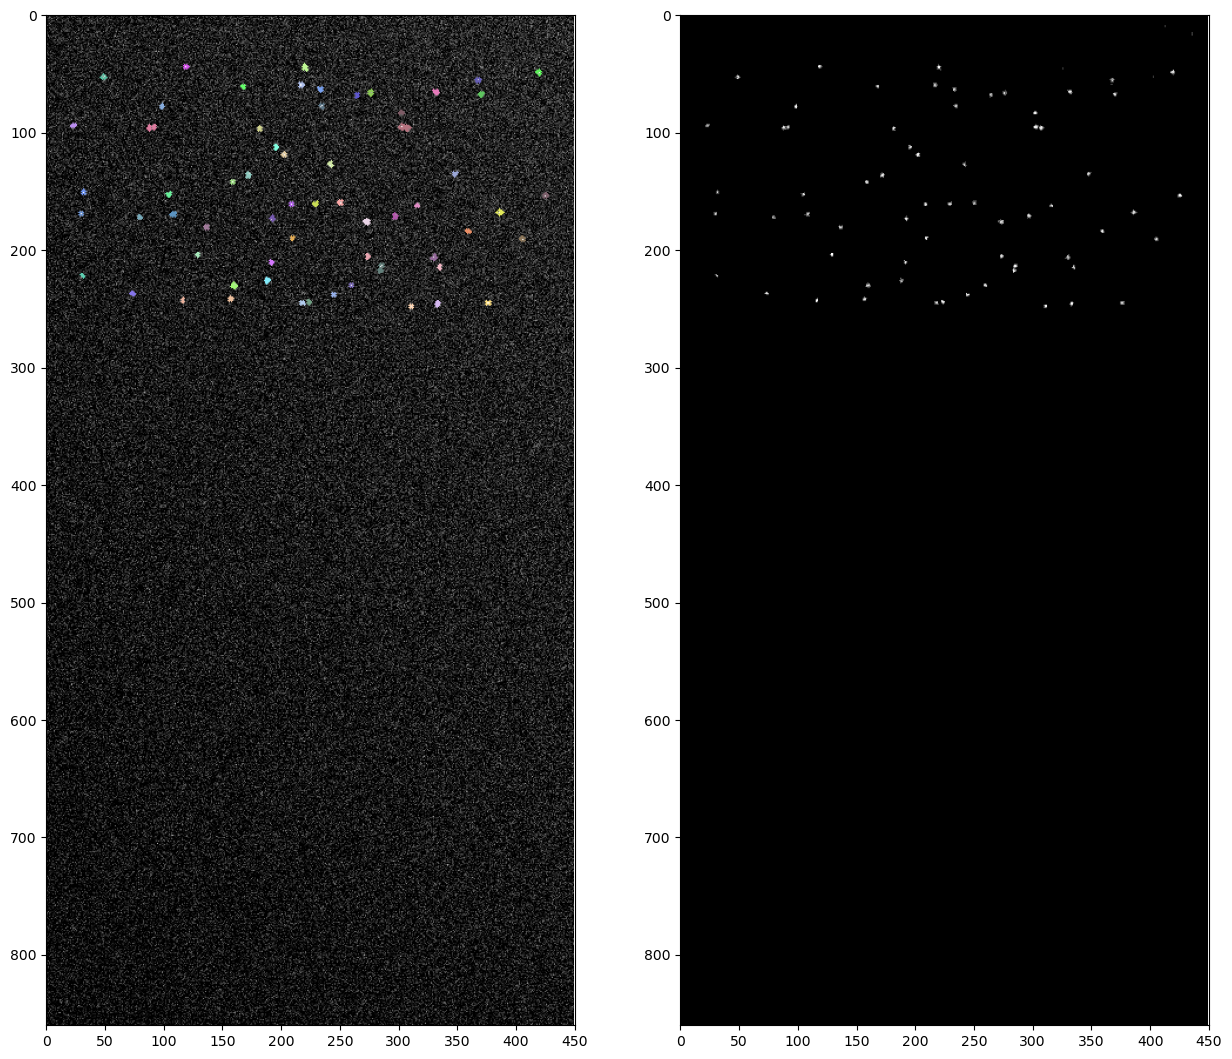

In [3]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

# Read the first image [z, x], convert to grayscale
img_rgb = cv.imread('PTV/a1.png')
img = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

# Bilateral filter
# VALUES WITHOUT TRHESHOLD:
# img_proc = cv.bilateralFilter(img, d=-1, sigmaColor=50, sigmaSpace=7)
# img_proc = cv.bilateralFilter(img_proc, d=-1, sigmaColor=20, sigmaSpace=3)
img_proc = cv.bilateralFilter(img, d=-1, sigmaColor=50, sigmaSpace=9)
img_proc = cv.bilateralFilter(img_proc, d=-1, sigmaColor=20, sigmaSpace=3)

# Rest of noise to zero
_, img_proc = cv.threshold(img_proc, 50, 255, cv.THRESH_TOZERO)

# Open the image
# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
# img_proc = cv.morphologyEx(img_proc, cv.MORPH_TOPHAT, kernel)
# img_proc = img_proc-img_tophat
kernel = np.ones((1,1),np.uint8)
img_proc = cv.morphologyEx(img_proc, cv.MORPH_OPEN, kernel)


# Perform a hit-or-miss transform on a binary version to remove all pixels with 
# only black neighbours on all sides
kernel = np.int8([[0, -1, 0],
                  [-1, +1, -1],
                  [0, -1, 0]])
img_binary = cv.threshold(img_proc, 0, 255, cv.THRESH_BINARY)[1]
img_singles = cv.morphologyEx(img_binary, cv.MORPH_HITMISS, kernel)
img_proc[img_singles == 255] = 0

# Find the contours
cnts, _ = cv.findContours(img_proc, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Filter out contours that are too small
cnts = [cnt for cnt in cnts if cv.contourArea(cnt) > 1]

# Draw the contours with random colours
img_cnt = img_rgb.copy()
for cnt in cnts:
    color = np.random.randint(85, 255, 3, dtype=np.uint8)
    img_cnt = cv.drawContours(img_cnt, cnt, -1, 
                               (int(color[0]), int(color[1]), int(color[2])), 2)

# Show the image and the processed image next to each other
# roi = [100, 200, 100, 200]
roi = [860, 0, 0, 450]
# roi = [100, 0, 350, 450]

fig, ax = plt.subplots(1,2, figsize = (15, 15))
ax[0].imshow(img_cnt, cmap = 'gray')
ax[1].imshow(img_proc, cmap = 'gray')

ax[0].set_xlim(roi[2], roi[3]); ax[0].set_ylim(roi[0], roi[1])
ax[1].set_xlim(roi[2], roi[3]); ax[1].set_ylim(roi[0], roi[1])
plt.show()

In [73]:
# Cycle through the contours
# for cnt in contours_filter:

# Double:
cnt = cnts[14]
# Single maximum shared by pixels:
# cnt = cnts[1]

# Single:
cnt = cnts[3]



# Get the bounding box of the contour
x, z, w, h = cv.boundingRect(cnt)

# Get the intensities of the pixels in the bounding box + margin as a 2D array
box_marg = 2
box_int = (img[(z - box_marg):(z + h + box_marg),
           (x - box_marg):(x + w + box_marg)]
           .reshape(h + 2 * box_marg, w + 2 * box_marg))
box_int_proc = (img_proc[(z - box_marg):(z + h + box_marg),
                (x - box_marg):(x + w + box_marg)]
                .reshape(h + 2 * box_marg, w + 2 * box_marg))

# TODO: Set pixels that are on another contour to zero
# cnts_other = [c for c in cnts if c is not cnt]
# mask = np.zeros_like(box_int)
# mask = cv.drawContours(mask, cnts[4], -1, 255, -1)
# box_int = np.where(mask != 255, box_int, 0)

# Get the image coordinates corresponding to each of these pixels
box_idx = np.indices((h + 2 * box_marg, w + 2 * box_marg))

# Get the real x and z coordinates
box_px = box_idx + np.array([z - box_marg, x - box_marg])[:, None, None]

# Maximum filter on this (processed) region
box_int_max = ndimage.maximum_filter(box_int_proc, size=3)

# Filter out maxima of 0 at the edges
box_int_max = np.where(box_int_max == 0, -1, box_int_max)

# Get indices
box_idx_max = box_idx[:, box_int_proc == box_int_max]
box_px_max = box_idx_max + np.array([z - box_marg, x - box_marg])[:, None]

# TODO: Count number of local maxima: if they are neighbours (@ given 
#  EUclidian distance) of each other,
#       they will be treated together, otherwise they must be two separate blobs

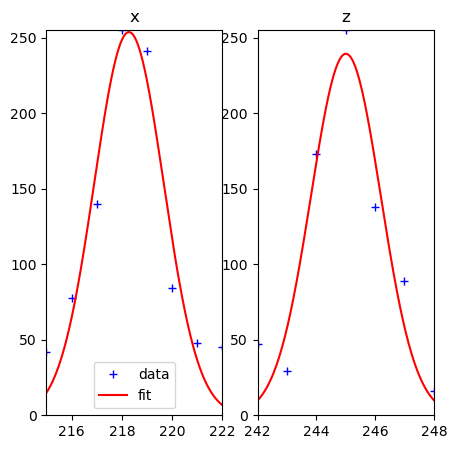

In [83]:

# SUBPIXEL DETECTION
# When only one maximum was detected, the entire region can be used to fit a 
# Gaussian in two directions

# Use curve_fit to fit a Gaussian to the region
def gaussian(x, a, x0, sigma):
    return a * np.exp(-((x - x0)**2) / (2 * sigma**2))

# Get slices around box_idx_max in the x and z direction
row_px = box_px[1, box_idx_max[0], :].flatten()
col_px = box_px[0, :, box_idx_max[1]].flatten()

row_int = box_int[box_idx_max[0], :].flatten()
col_int = box_int[:, box_idx_max[1]].flatten()

# Initial parameters
# TODO: Change sigma to number of pixels that are at maximum
a = box_int[*box_idx_max][0]
x0 = box_px_max[1][0]
z0 = box_px_max[0][0]
sigma_x = 1
sigma_z = 1

popt_row, _ = curve_fit(gaussian, row_px, row_int, p0=[a, x0, sigma_x])
popt_col, _ = curve_fit(gaussian, col_px, col_int, p0=[a, z0, sigma_z])

# Generate a finer grid
step_size = 0.001
row_px_fit = np.arange(row_px.min(), row_px.max(), step_size)
col_px_fit = np.arange(col_px.min(), col_px.max(), step_size)

row_int_fit = gaussian(row_px_fit, *popt_row)
col_int_fit = gaussian(col_px_fit, *popt_col)

# Get the coordinates of the maximum of the Gaussian
x_max = popt_row[1]
z_max = popt_col[1]

# Show the fits in x and z next to each other
fig, ax = plt.subplots(1,2, figsize = (5, 5))
ax[0].plot(row_px, row_int, 'b+', label='data')
ax[0].plot(row_px_fit, row_int_fit, 'r-', label='fit')
ax[0].set_xlim(row_px.min(), row_px.max())
ax[0].set_ylim(row_int.min(), row_int.max())
ax[0].set_title('x')
ax[0].set_ylim(0, 255)
ax[0].legend()

ax[1].plot(col_px, col_int, 'b+', label='data')
ax[1].plot(col_px_fit, col_int_fit, 'r-', label='fit')
ax[1].set_xlim(col_px.min(), col_px.max())
ax[1].set_ylim(col_int.min(), col_int.max())
ax[1].set_ylim(0, 255)
ax[1].set_title('z')

plt.show()


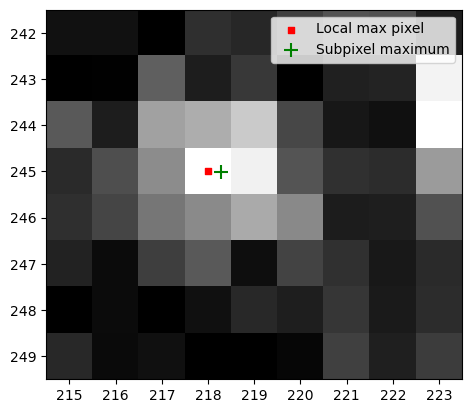

In [84]:
# # Get all pixels enclosed by the contour
# mask = np.zeros_like(img_proc)
# mask = cv.drawContours(mask, [cnt], -1, 255, -1)
# 
# # Get the x and z coordinates and intensities of the pixels
# cnt_coords = np.array(np.where(mask == 255))
# # box_int = img[np.where(mask == 255)]

# # Get 2D local maxima in this blob
# peaks, _ = find_peaks(box_int, distance=5, prominence=5)


# Show this contour on the original image
fig, ax = plt.subplots()
ax.imshow(img, cmap = 'gray')
ax.set_xlim(x - box_marg - 0.5, x + w + box_marg + 0.5)
ax.set_ylim(z + h + box_marg + 0.5, z - box_marg - 0.5)

# Scatter plot of peaks
ax.scatter(*np.flipud(box_px_max), c ='r', s = 20, marker = 's',
           label = 'Local max pixel')
ax.scatter(x_max, z_max, c = 'g', s = 100, marker = '+',
           label = 'Subpixel maximum')
plt.legend()
plt.show()



In [ ]:
# Simple blob detection
detector = cv.SimpleBlobDetector()

# Detect blobs.
keypoints = detector.detect(img_proc)

# Draw detected blobs as red circles.
# cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
img_with_keypoints = cv.drawKeypoints(img_proc, keypoints, np.array([]), 
                                      (0, 255, 0),
                                      cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show keypoints
fig, ax = plt.subplots(1,1, figsize = (15, 15))

ax.imshow(img_with_keypoints, cmap = 'gray')
ax.set_xlim(roi[2], roi[3])
ax.set_ylim(roi[0], roi[1])
plt.show()
